In [70]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
param_fp = Path('/bsuhome/zacharykeskinen/spicy-analysis/data/')
ds = xr.open_dataset(param_fp.joinpath('param_stats.nc'))
ds = ds.sel(C = slice(0.01, 1))

/tmp/ipykernel_956/2579277249.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_956/2579277249.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


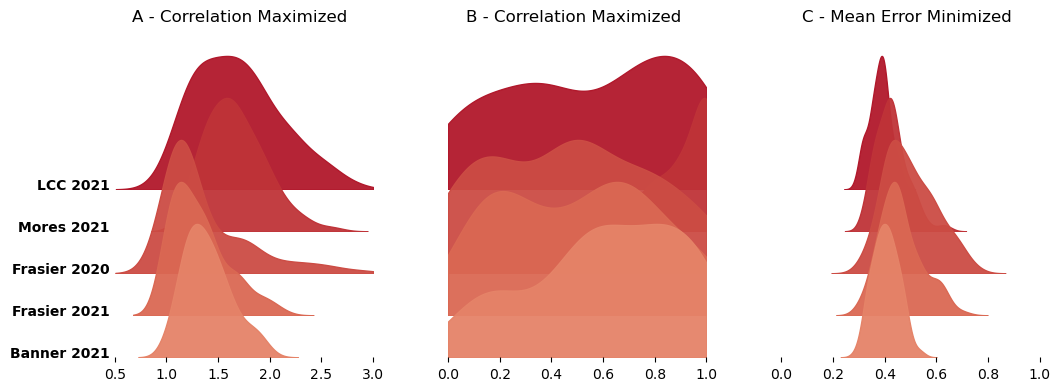

In [72]:
import matplotlib.gridspec as grid_spec
from matplotlib import colormaps
cmap = colormaps.get_cmap('RdBu')
colors = cmap(np.linspace(0.1, 0.4, len(ds.location)))

fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 3, wspace=0.07)
params = ['A', 'B', 'C']

loc_sorted = ['Little_Cottonwood_2021-03-18', 'Mores_2021-03-15',\
       'Frasier_2020-02-11','Frasier_2021-03-19', 'Banner_2021-03-15']  
       #,'Dry_Creek_2020-02-19', 'Cameron_2021-03-19',  'Mores_2020-02-09','Banner_2020-02-18',

sorted = ds.reindex(location = loc_sorted)

clips = [[0.5, 3], [0, 1], [0, 1]]

param_stat = {'A':'pearsonr', 'B':'pearsonr', 'C':'mae'}

for i, (param, subfig, clip,) in enumerate(zip(params, subfigs, clips)):
    axes = subfig.subplots(len(sorted.location), gridspec_kw = {'hspace': -0.7})
    other_params = params[:]
    other_params.remove(param)

    stat_name = param_stat[param]

    for loc, color, ax in zip(sorted.location, colors, axes):
        
        param_1, param_2 = other_params

        loc_ds = sorted.sel(location = loc)

        a = loc_ds.loc[{param_1 : loc_ds[param_stat[param_1]].idxmax(param_1)}]
        if param_2 == 'C':
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmin(param_2)}]
        else:
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmax(param_2)}]
        
        if param == 'C':
            data = data.idxmin(param)
        else:
            data = data.idxmax(param)
        
        data = data[param_stat[param]].data
        # data = data + np.random.random(data.shape)/1000

        sns.kdeplot(data, color = color, \
                    fill = True, alpha = 0.95, ax= ax, clip = clip, warn_singular=False, zorder = 1)
        ax.set_xlim(clip)
        ax.set_yticks([])
        ax.set_ylabel('')

        rect = ax.patch
        rect.set_alpha(0)

        spines = ["top", "right", "left", "bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)
        
        if i == 0:
            site_name = str(loc.data).replace('_', ' ').replace('Little Cottonwood', 'LCC').split('-')[0]
            ax.text(-0.02, 0, site_name, fontweight = 'bold', ha = 'right', transform = ax.transAxes, zorder = 1e5)


    for ax in axes[:-1]:
        ax.set_xticks([])

    stat_title= {'mae':'Mean Error Minimized', 'pearsonr':'Correlation Maximized'}
    subfig.suptitle(f'{param} - {stat_title[param_stat[param]]}')

plt.tight_layout()

Text(0, 0.5, 'Pearson R Correlation')

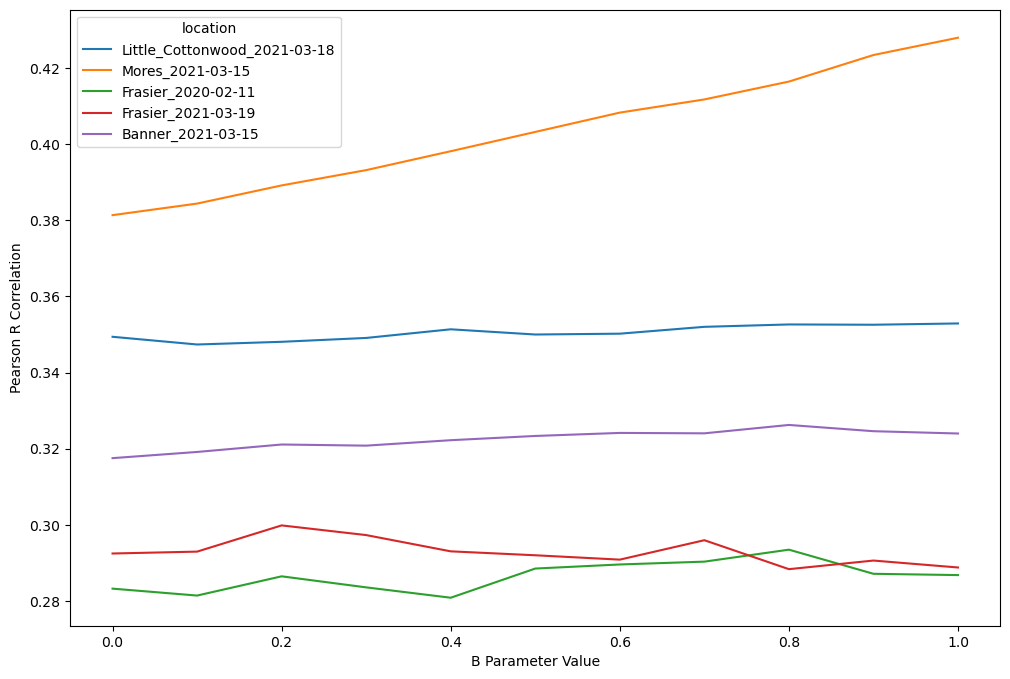

In [4]:
loc = ds.sel(location = loc_sorted)#.mean('iteration') # .isel(location = 8)

c_best = loc.sel(C = loc['mae'].idxmin('C'))
a_c_best = c_best.sel(A = c_best['pearsonr'].idxmax('A'))

min_ds = a_c_best.min('iteration')['pearsonr']
max_ds = a_c_best.max('iteration')['pearsonr']
mean_ds = a_c_best.mean('iteration')['pearsonr']

a_c_best['pearsonr'].mean('iteration').plot(hue = 'location', figsize = (12, 8))
plt.xlabel('B Parameter Value')
plt.ylabel('Pearson R Correlation')

# plt.legend(['Banner 2020', 'Banner 2021', 'Cameron 2021', 'Dry Creek 2020', 'Frasier 2020', 'Frasier 2021', 'LCC 2021', 'Mores 2020', 'Mores 2021'], loc = 'lower left')

# cmap = colormaps.get_cmap('RdBu')
# colors = cmap(np.linspace(0.1, 0.4, len(ds.location)))

# fig, ax = plt.subplots(figsize = (12, 8))

# for (loc, loc_ds), color in zip(min_ds.groupby('location'), colors):
#     ax.fill_between(loc_ds.B, loc_ds.data, max_ds.sel(location = loc).data, label = loc, color = color, alpha = 0.5)
#     ax.plot(loc_ds.B, mean_ds.sel(location = loc).data, color = color, zorder = 1e4)
# plt.legend()

# plt.xlabel('B Parameter Value')
# plt.ylabel('Pearson R Correlation')

Text(0.5, 0.98, 'Banner 2021 - Parameter Effects')

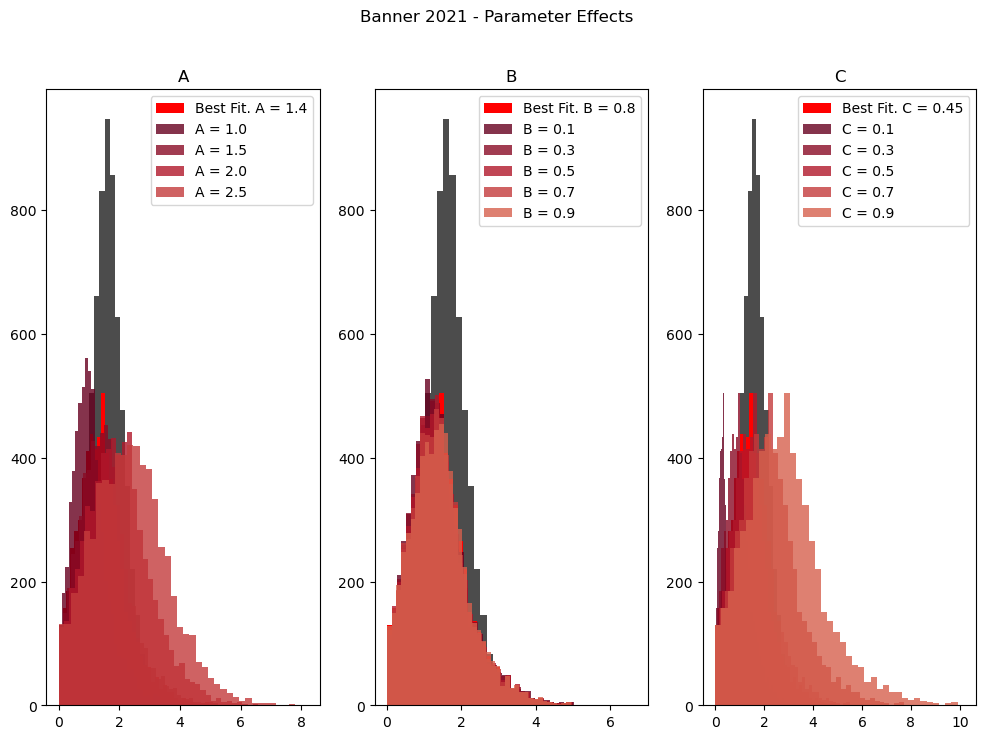

In [69]:
bins = 40
for (loc, loc_ds) in ds.groupby('location'):
    if 'Banner_2021' not in loc:
        continue

    fig, axes = plt.subplots(1, 3, figsize = (12, 8))

    for param, pr, ax in zip(['A', 'B', 'C'], [(1,3, 0.5), (0.1, 1, 0.2), (0.1, 1, 0.2)], axes):

            trees = np.load(param_fp.joinpath(loc, f"trees.npy"))
            elev = np.load(param_fp.joinpath(loc, f"elev.npy"))
            idx = (trees < 0.5) & (elev > 2000)

            lidar_sd = np.load(param_fp.joinpath(loc, f"lidar.npy"))[idx]

            ax.hist(lidar_sd, bins = bins, alpha = 0.7, color = 'black')

            it = loc_ds.mean('iteration')
            a = it.sel(A = it['pearsonr'].idxmax('A')) 
            ab = a.sel(B = a['pearsonr'].idxmax('B'))
            abc = ab.sel(C = ab['mae'].idxmin('C'))
            
            best_params = {'A':abc.A.data, 'B': abc.B.data, 'C': abc.C.data}

            f = param_fp.joinpath(loc, f"{best_params['A']}_{best_params['B']}_{best_params['C']}.npy")
            spicy_sd = np.load(f)[idx]
            ax.hist(spicy_sd[spicy_sd > 0], bins = bins, label = f'Best Fit. {param.capitalize()} = {best_params[param]}', color = 'red')
            
            for i, c in enumerate(np.round(np.arange(pr[0], pr[1], pr[2]), 2)):
                best_params[param] = c
                f = param_fp.joinpath(loc, f"{best_params['A']}_{best_params['B']}_{best_params['C']}.npy")
                spicy_sd = np.load(f)[idx]
                ax.hist(spicy_sd[spicy_sd > 0], bins = bins, label = f'{param.capitalize()} = {c}', color = cmap(i / 20), alpha = 0.8)

            ax.set_title(param.capitalize())
            ax.legend()
plt.suptitle('Banner 2021 - Parameter Effects')

In [73]:
best_params

{'A': array(1.4), 'B': array(0.8), 'C': 0.9}